Epoch: 0, Train Loss: 1.5109, Test Acc: 0.5667
Epoch: 1000, Train Loss: 0.2229, Test Acc: 0.9389
Epoch: 2000, Train Loss: 0.2115, Test Acc: 0.9411
Epoch: 3000, Train Loss: 0.2063, Test Acc: 0.9389
Epoch: 4000, Train Loss: 0.2035, Test Acc: 0.9389


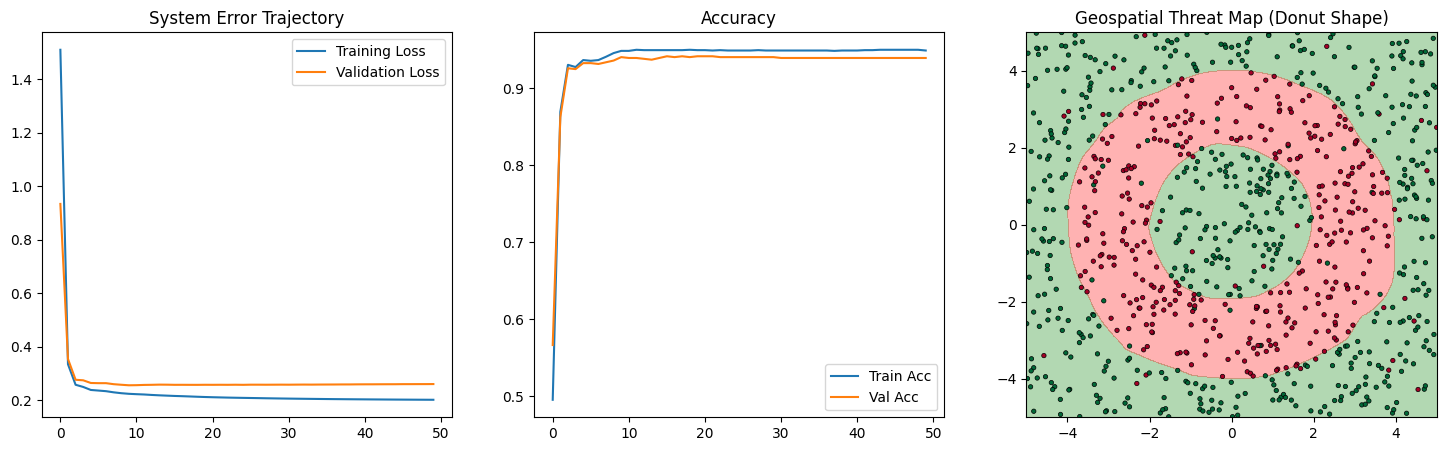

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

GROUP_NUMBER = 9

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """Generates sensor readings for the Kepler-186f Exclusion Zone."""
    X = (torch.rand(n_samples, 2) * 10) - 5
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices]

    return X, y

# Generate data
X_full, y_full = generate_data(3000)
X_extra = X_full**2
X_combined = torch.cat((X_full, X_extra), dim=1)
X_numpy = X_combined.numpy()
y_numpy = y_full.numpy()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=0.3, random_state=GROUP_NUMBER
)

#Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

#Convert back to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

w1 = (torch.randn(4, 16) * 0.5).requires_grad_(True)
b1 = torch.zeros(1, 16, requires_grad=True)

w2 = (torch.randn(16, 16) * 0.5).requires_grad_(True)
b2 = torch.zeros(1, 16, requires_grad=True)

w3 = (torch.randn(16, 16) * 0.5).requires_grad_(True)
b3 = torch.zeros(1, 16, requires_grad=True)

w4 = (torch.randn(16, 1) * 0.5).requires_grad_(True)
b4 = torch.zeros(1, 1, requires_grad=True)

parameters = [w1, b1, w2, b2, w3, b3, w4, b4]

def forward_pass(X):
    Z1 = torch.matmul(X, w1) + b1
    A1 = torch.relu(Z1)

    Z2 = torch.matmul(A1, w2) + b2
    A2 = torch.relu(Z2)

    Z3 = torch.matmul(A2, w3) + b3
    A3 = torch.relu(Z3)

    Z4 = torch.matmul(A3, w4) + b4
    A4 = torch.sigmoid(Z4)
    return A4

def BCE_LOSS(y_pred, y_true):
    y_pred_clipped = torch.clamp(y_pred, 1e-7, 1-1e-7)
    term1 = y_true * torch.log(y_pred_clipped)
    term2 = (1 - y_true) * torch.log(1 - y_pred_clipped)
    return -torch.mean(term1 + term2)

initial_rate = 0.2
decay_rate = 0.9995
epochs = 5000

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    learning_rate = initial_rate * (decay_rate ** epoch)

    # Forward & Loss
    y_pred = forward_pass(X_train_tensor)
    current_loss = BCE_LOSS(y_pred, y_train_tensor)

    # Backward
    current_loss.backward()

    # Update
    with torch.no_grad():
        for param in parameters:
            if param.grad is not None:
                param.data -= learning_rate * param.grad
                param.grad.zero_()

    #Evaluation
    if epoch % 100 == 0:
        with torch.no_grad():
            y_pred_test = forward_pass(X_test_tensor)
            test_loss = BCE_LOSS(y_pred_test, y_test_tensor)

            train_preds = (y_pred >= 0.5).float()
            test_preds = (y_pred_test >= 0.5).float()
            acc_train = (train_preds == y_train_tensor).float().mean()
            acc_test = (test_preds == y_test_tensor).float().mean()

            train_losses.append(current_loss.item())
            test_losses.append(test_loss.item())
            train_accs.append(acc_train.item())
            test_accs.append(acc_test.item())

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch}, Train Loss: {current_loss.item():.4f}, Test Acc: {acc_test.item():.4f}")


fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(test_losses, label='Validation Loss')
ax[0].set_title("System Error Trajectory")
ax[0].legend()

ax[1].plot(train_accs, label='Train Acc')
ax[1].plot(test_accs, label='Val Acc')
ax[1].set_title("Accuracy")
ax[1].legend()

x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x_range, y_range)

grid_flat = np.c_[xx.ravel(), yy.ravel()]
grid_extra = grid_flat**2
grid_combined_raw = np.hstack((grid_flat, grid_extra))

grid_scaled = scaler.transform(grid_combined_raw)
grid_tensor = torch.tensor(grid_scaled, dtype=torch.float32)

with torch.no_grad():
    Z = forward_pass(grid_tensor)
    Z = Z.detach().numpy().reshape(xx.shape)

ax[2].contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['green', 'red'])

y_colors = y_test_tensor.flatten().numpy()
ax[2].scatter(X_test_raw[:, 0], X_test_raw[:, 1], c=y_colors, s=10, cmap='RdYlGn_r', edgecolors='k', linewidth=0.5)
ax[2].set_title("Geospatial Threat Map (Donut Shape)")

plt.show()